## Directory

```bash
├── open
│   ├── train
│   ├── test
│   ├── sample_submission.csv
├── project.ipynb
```

## OS

-  Microsoft Windows 10 Pro (버전 10.0.19043 빌드 19043)
-  Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz, 2112Mhz, 4 코어, 8 논리 프로세서
-  GPU 사용 X

## Version

-  Python: 3.10.4 <br>
-  opencv: 4.5.5 <br>
-  numpy: 1.22.3 <br>
-  pandas: 1.4.2 <br>
-  torch: 1.11.0+cpu <br>
-  tensorflow: 2.8.0 

## Import

In [32]:
import os
from glob import glob

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from itertools import groupby 
import random

import plotly.express as px 
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostRegressor 
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [7]:
main_path = "./open"
train_imgs = glob(main_path + "/train/*/*/*.png") + glob(main_path + "/train/*/*/*.jpg")
train_imgs = sorted(train_imgs)
test_imgs = glob(main_path + "/test/image/*.png") + glob(main_path + "/test/image/*.jpg")
test_imgs = sorted(test_imgs)
train_data = glob(main_path + "/train/*/meta/*.csv")
train_data = sorted(train_data)
train_label = glob(main_path + "/train/*/*.csv")
train_label = sorted(train_label)
test_data = glob(main_path + "/test/meta/*.csv")
test_data = sorted(test_data)

preprocessing_train_imgs = main_path + "/PREPROCESSING-TRAIN"
preprocessing_test_imgs = main_path + "/PREPROCESSING-TEST"

if not os.path.exists(preprocessing_train_imgs):
    os.mkdir(preprocessing_train_imgs)
if not os.path.exists(preprocessing_test_imgs):
    os.mkdir(preprocessing_test_imgs)

## Image Augmentation

-  Grayscale histogram 이용해 모든 청경채 이미지 밝기 자동으로 조절하기

In [8]:
def automatic_brightness_and_contrast(image, clip_hist_percent=0.025):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Calculate grayscale histogram
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)
    
    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))
    
    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0
    
    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1
    
    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1

    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha
    
    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return (auto_result)

## Data Processing

-  이미지 밝기 조절 후 HSV를 사용하여 특정 색상 Object 추출하기
-  마스킹 된 이미지 픽셀 비율 값 추출 (하얀 픽셀 수 / 하얀 픽셀 수 + 검은 픽셀 수)

In [9]:
def get_image_data(dir_in, dir_out):
    ratio_list = []

    for i in tqdm(dir_in):
        name = i.split("\\")[-1]  # i.split("/")[-1]
        img = cv2.imread(i, cv2.IMREAD_COLOR)
        img = cv2.resize(img,(615,462))
        brightscale = automatic_brightness_and_contrast(img)
        imgcopy = brightscale.copy()
        hsvimage = cv2.cvtColor(brightscale, cv2.COLOR_BGR2HSV)
        lower = np.array([22,40,0])
        upper = np.array([85,255,245])
        mask = cv2.inRange(hsvimage, lower, upper)
        number_of_white_pix = np.sum(mask == 255)
        number_of_black_pix = np.sum(mask == 0)
        ratio = number_of_white_pix / (number_of_white_pix + number_of_black_pix)
        ratio_list.append(ratio)
        result = cv2.bitwise_and(imgcopy, imgcopy, mask=mask)
        cv2.imwrite(os.path.join(dir_out,name), result)
    
    return ratio_list

ratio_train = get_image_data(train_imgs, preprocessing_train_imgs)
ratio_test = get_image_data(test_imgs, preprocessing_test_imgs)

processed_train_imgs = glob(main_path+"/PREPROCESSING-TRAIN/*.png") + glob(main_path+"/PREPROCESSING-TRAIN/*.jpg")
processed_train_imgs = sorted(processed_train_imgs)

processed_test_imgs = glob(main_path+"/PREPROCESSING-TEST/*.png") + glob(main_path+"/PREPROCESSING-TEST/*.jpg")
processed_test_imgs = sorted(processed_test_imgs)

100%|██████████| 460/460 [01:45<00:00,  4.35it/s]


-  정량이 정해져 있는 변수는 bbfill, ffill로 곁측값 대체 (최근분무량)
-  정량이 정해져 있지 않은 변수는 interpolate (그외)
-  일부 최근분무량 데이터는 최근분무량이 아닌 일간누적분무량으로 측정이 되어 모든 최근분무량 데이터를 일간누적분무량으로 변환
-  환경 데이터 일 단위 평균으로 aggregate
-  메타데이터에 픽셀 비율 feature 변수로 포함하기

In [36]:
train_df = []
for i in tqdm(train_data):
    name = i.split("\\")[-1].split(".")[0]  # i.split("/")[-1].split(".")[0]
    df = pd.read_csv(i)
    df = df.drop('시간', axis = 1)
    case = name.split("_")[0]
    label = pd.read_csv(main_path + f"/train/{case}/label.csv")
    label_name = [i.split(".")[0] for i in label.img_name]
    label.img_name = label_name
    leaf_weight = label[label.img_name == name].leaf_weight.values[0]
    df["무게"] = leaf_weight
    df["최근분무량"] = df["최근분무량"].fillna(method='bfill', limit=1)
    df["최근분무량"] = df["최근분무량"].fillna(method='ffill', limit=1)
    df = df.interpolate()
    water = df['최근분무량'].round(2).tolist()
    if np.mean(water) > 1000:
        nums = [list(v) for k,v in groupby(water, key = lambda x: x != 0) if k != 0]
        if len(nums) == 2:
            cumulative = nums[0][-1] - nums[0][0] + nums[1][-1]
        else:
            cumulative = nums[0][-1] - nums[0][0]
            
    elif 1000 > np.mean(water) > 0:
        nums = [key for key, _group in groupby(water)]
        cumulative = sum(nums[1:])
    else:
        cumulative = 0

    df = df.mean()
    df = df.to_frame().T
    df["이미지"] = name
    df['최근분무량'] = cumulative

    train_df.append(df)

train_df = pd.concat(train_df, ignore_index=True)
train_df['비율'] = ratio_train
train_df.head()

100%|██████████| 1592/1592 [00:27<00:00, 56.95it/s]


,내부온도관측치,외부온도관측치,내부습도관측치,외부습도관측치,CO2관측치,EC관측치,최근분무량,화이트 LED동작강도,레드 LED동작강도,블루 LED동작강도,...,냉방부하,난방온도,난방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,무게,이미지,비율
0,22.236181,43.868542,77.740695,4.679291,487.226389,19.594792,0.0,200.720833,201.000000,0.139583,...,179.460356,18.854103,10.228598,145.944829,12.396061,21.119466,NaN,49.193,CASE01_01,0.099880
1,23.011319,44.573750,77.645972,4.537500,480.144444,20.855555,0.0,200.861111,200.861111,0.139583,...,179.471631,18.853965,13.709128,145.980283,12.391464,21.099885,NaN,59.764,CASE01_02,0.120072
2,22.931111,39.537708,77.514931,4.886111,489.068750,20.748611,0.0,200.651042,200.373264,0.139583,...,179.523570,18.854171,13.348331,146.015736,12.374227,21.133608,NaN,72.209,CASE01_03,0.141692
3,21.027986,58.497500,80.069930,3.908333,481.378472,18.195278,0.0,200.025000,200.163889,0.139583,...,179.495845,18.854174,7.520480,145.997472,12.370205,21.128169,NaN,85.737,CASE01_04,0.166315
4,21.874305,67.058819,81.349792,3.908333,490.568750,19.400486,0.0,200.861111,201.000000,0.139583,...,179.488241,18.854140,10.943552,145.971688,12.394912,21.121642,NaN,102.537,CASE01_05,0.191525


In [35]:
test_df = []
for i in tqdm(test_data):
    name = i.split("\\")[-1].split(".")[0]  # i.split("/")[-1].split(".")[0]
    df = pd.read_csv(i)
    df = df.drop('시간', axis = 1)
    df["최근분무량"] = df["최근분무량"].fillna(method='bfill', limit=1)
    df["최근분무량"] = df["최근분무량"].fillna(method='ffill', limit=1)
    df = df.interpolate()
    water = df['최근분무량'].round(2).tolist()
    if np.mean(water) > 1000:
        nums = [list(v) for k,v in groupby(water, key = lambda x: x != 0) if k != 0]
        if len(nums) == 2:
            cumulative = nums[0][-1] - nums[0][0] + nums[1][-1]
        else:
            cumulative = nums[0][-1] - nums[0][0]
            
    elif 1000 > np.mean(water) > 0:
        nums = [key for key, _group in groupby(water)]
        cumulative = sum(nums[1:])
    else:
        cumulative = 0

    df = df.mean()
    df = df.to_frame().T
    df["이미지"] = name
    df['최근분무량'] = cumulative

    test_df.append(df)

test_df = pd.concat(test_df, ignore_index=True)
test_df['비율'] = ratio_test  
test_df.head()

100%|██████████| 460/460 [00:08<00:00, 54.56it/s]


,내부온도관측치,외부온도관측치,내부습도관측치,외부습도관측치,CO2관측치,EC관측치,최근분무량,화이트 LED동작강도,레드 LED동작강도,블루 LED동작강도,냉방온도,냉방부하,난방온도,난방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,이미지,비율
0,23.634861,22.564583,69.500486,34.499792,400.265278,0.000000,11509.28,47.195486,7.484722,13.488194,22.395829,6.198268,20.395829,0.000000,179.576697,146.045817,12.398359,21.132520,001,0.162299
1,27.170347,28.738472,63.881805,50.837708,505.823611,0.000000,4234.63,33.496181,9.506597,4.722222,23.396007,23.875345,22.396007,0.000000,126.724400,103.602930,15.725197,7.396273,002,0.526678
2,25.999340,25.541111,79.197812,65.936597,498.623611,1.778872,610.71,47.185417,7.487153,13.476736,20.291920,42.908664,17.416844,0.606961,179.532997,146.026479,12.390315,21.116202,003,0.011593
3,22.956944,22.361667,70.809792,45.378646,394.612500,0.592409,12271.85,47.183333,7.483333,13.479514,22.395793,2.911434,20.395793,0.000000,179.449739,145.950201,12.392039,21.107500,004,0.149154
4,23.014757,22.531736,73.886944,33.534167,418.561806,0.541303,13040.85,47.185417,7.466667,13.478125,22.395846,3.179260,20.395846,0.000000,179.480870,145.998546,12.365033,21.117290,005,0.168588


## Image EDA

-  산점도 플롯 이용해서 무게, 픽셀 비율 관계 살펴보기. 회귀선에 멀리 떨어져 있는 값은 이상값으로 판단하여 제거하기
-  CASE59는 CASE58의 중복 데이터이므로 제거하기 

In [37]:
fig = px.scatter(train_df, x = '무게', y= '비율',
                 hover_name="이미지", trendline="ols")

fig.show()

In [38]:
image_outliers = ['CASE05_21','CASE05_22','CASE05_23', 'CASE07_07', 'CASE07_08', 'CASE16_03', 'CASE23_01', 'CASE23_02', 
'CASE23_03', 'CASE23_04', 'CASE23_05', 'CASE23_06', 'CASE23_07', 'CASE23_08', 'CASE23_09', 'CASE45_16', 'CASE45_17',
'CASE72_06',  'CASE73_10', 'CASE59_01','CASE59_02','CASE59_03','CASE59_04','CASE59_05','CASE59_06',
'CASE59_07','CASE59_08','CASE59_09','CASE59_10','CASE59_11','CASE59_12','CASE59_13','CASE59_14','CASE59_15','CASE59_16','CASE59_17','CASE59_18',
'CASE59_19','CASE59_20','CASE59_21','CASE59_22','CASE59_23','CASE59_24','CASE59_25','CASE59_26','CASE59_27','CASE59_28','CASE59_29','CASE59_30',
'CASE59_31','CASE59_32', 'CASE59_33']

train_df_image = train_df[~train_df['이미지'].isin(image_outliers)]
train_imgs_removed = [ x for x in processed_train_imgs if x.split(".")[1].split("\\")[1] not in image_outliers]  # x.split(".")[1].split("/")[3]

## Baseline CNN Fit

-  Model Architecture 그리고 트레이닝 과정은 베이스라인 코드와 일치합니다. 하이퍼 파라미터 / 데이터 Path만 수정했습니다.

In [39]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")

The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator


In [40]:
CFG = {
    'IMG_SIZE':128,
    'EPOCHS':80,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':32,
    'SEED':42
}

In [41]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [42]:
train_len = int(len(train_imgs_removed)*0.8)
weight = train_df_image['무게'].round(3).tolist()

train_img_path = train_imgs_removed[:train_len]
train_label = weight[:train_len]

vali_img_path = train_imgs_removed[train_len:]
vali_label = weight[train_len:]

In [43]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True, transforms=None):
        self.transforms = transforms 
        self.train_mode = train_mode
        self.img_path_list = img_path_list
        self.label_list = label_list

    def __getitem__(self, index): # Use index when calling images
        img_path = self.img_path_list[index]
        # Get image data
        image = cv2.imread(img_path)
        if self.transforms is not None:
            image = self.transforms(image)

        if self.train_mode:
            label = self.label_list[index]
            return image, label
        else:
            return image
    
    def __len__(self): # Returns number of training data 
        return len(self.img_path_list)

In [44]:
train_transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                    ])

test_transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                    ])

In [45]:
train_dataset = CustomDataset(train_img_path, train_label, train_mode=True, transforms=train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

vali_dataset = CustomDataset(vali_img_path, vali_label, train_mode=True, transforms=test_transform)
vali_loader = DataLoader(vali_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [46]:
class CNNRegressor(torch.nn.Module):
    def __init__(self):
        super(CNNRegressor, self).__init__()
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = torch.nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer4 = torch.nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.regressor = nn.Linear(3136,1)


    def forward(self, x):
        # Simple CNN Model (Batch, 3, 128, 128 -> Batch, 64, 7, 7)
        # (Batch, 3, 128, 128)
        x = self.layer1(x)
        # (Batch, 8, 64, 64)
        x = self.layer2(x)
        # (Batch, 16, 32, 32)
        x = self.layer3(x)
        # (Batch, 32, 16, 16)
        x = self.layer4(x)
        # (Batch, 64, 7, 7) -> Flatten (Batch, 64*7*7(=3136))
        x = torch.flatten(x, start_dim=1)
        # Regressor (Batch, 3136) -> (Batch, 1)
        out = self.regressor(x)
        return out

In [47]:
def train(model, optimizer, train_loader, vali_loader, scheduler, device):
    model.to(device)

    # Loss Function
    criterion = nn.L1Loss().to(device)
    best_mae = 9999
    
    for epoch in range(1,CFG["EPOCHS"]+1):
        model.train()
        train_loss = []
        for img, label in tqdm(iter(train_loader)):
            img, label = img.float().to(device), label.float().to(device)
            
            optimizer.zero_grad()

            # Data -> Model -> Output
            logit = model(img)
            # Calc loss
            loss = criterion(logit.squeeze(1), label)

            # backpropagation
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            
        if scheduler is not None:
            scheduler.step()
            
        # Evaluation Validation set
        vali_mae = validation(model, vali_loader, criterion, device)
        
        print(f'Epoch [{epoch}] Train MAE : [{np.mean(train_loss):.5f}] Validation MAE : [{vali_mae:.5f}]\n')
        
        # Model Saved
        if best_mae > vali_mae:
            best_mae = vali_mae
            torch.save(model.state_dict(), './best_model.pth')
            print('Model Saved.')

In [48]:
def validation(model, vali_loader, criterion, device):
    model.eval() # Evaluation
    vali_loss = []
    with torch.no_grad():
        for img, label in tqdm(iter(vali_loader)):
            img, label = img.float().to(device), label.float().to(device)

            logit = model(img)
            loss = criterion(logit.squeeze(1), label)
            
            vali_loss.append(loss.item())

    vali_mae_loss = np.mean(vali_loss)
    return vali_mae_loss

In [49]:
CNNmodel = CNNRegressor().to(device)

optimizer = torch.optim.SGD(params = CNNmodel.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = None

train(CNNmodel, optimizer, train_loader, vali_loader, scheduler, device)

100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


Epoch [1] Train MAE : [77.63341] Validation MAE : [85.81693]

Model Saved.


100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


Epoch [2] Train MAE : [77.04366] Validation MAE : [81.66288]

Model Saved.


100%|██████████| 10/10 [00:04<00:00,  2.22it/s]


Epoch [3] Train MAE : [70.42951] Validation MAE : [75.58188]

Model Saved.


100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


Epoch [4] Train MAE : [69.71277] Validation MAE : [74.72727]

Model Saved.


100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


Epoch [5] Train MAE : [70.05750] Validation MAE : [74.81187]



100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


Epoch [6] Train MAE : [69.90649] Validation MAE : [75.91533]



100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


Epoch [7] Train MAE : [69.69950] Validation MAE : [75.58545]



100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


Epoch [8] Train MAE : [69.39545] Validation MAE : [75.28512]



100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


Epoch [9] Train MAE : [69.87750] Validation MAE : [74.38873]

Model Saved.


100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


Epoch [10] Train MAE : [69.35142] Validation MAE : [73.42561]

Model Saved.


100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


Epoch [11] Train MAE : [67.75403] Validation MAE : [67.89522]

Model Saved.


100%|██████████| 10/10 [00:03<00:00,  2.72it/s]


Epoch [12] Train MAE : [61.36704] Validation MAE : [65.46505]

Model Saved.


100%|██████████| 10/10 [00:04<00:00,  2.48it/s]


Epoch [13] Train MAE : [58.40381] Validation MAE : [57.79212]

Model Saved.


100%|██████████| 10/10 [00:03<00:00,  2.77it/s]


Epoch [14] Train MAE : [57.50720] Validation MAE : [39.93770]

Model Saved.


100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


Epoch [15] Train MAE : [47.62180] Validation MAE : [63.80789]



100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


Epoch [16] Train MAE : [61.75825] Validation MAE : [75.28036]



100%|██████████| 10/10 [00:03<00:00,  2.75it/s]


Epoch [17] Train MAE : [68.27056] Validation MAE : [73.69141]



100%|██████████| 10/10 [00:03<00:00,  2.85it/s]


Epoch [18] Train MAE : [54.09547] Validation MAE : [33.80278]

Model Saved.


100%|██████████| 10/10 [00:03<00:00,  2.74it/s]


Epoch [19] Train MAE : [65.00758] Validation MAE : [72.32714]



100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


Epoch [20] Train MAE : [68.21992] Validation MAE : [78.70307]



100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


Epoch [21] Train MAE : [66.95136] Validation MAE : [67.85972]



100%|██████████| 10/10 [00:03<00:00,  2.76it/s]


Epoch [22] Train MAE : [63.88951] Validation MAE : [62.88478]



100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


Epoch [23] Train MAE : [56.56537] Validation MAE : [48.32113]



100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


Epoch [24] Train MAE : [40.83120] Validation MAE : [30.90375]

Model Saved.


100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


Epoch [25] Train MAE : [38.24281] Validation MAE : [19.27695]

Model Saved.


100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


Epoch [26] Train MAE : [17.58395] Validation MAE : [40.04608]



100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


Epoch [27] Train MAE : [13.58026] Validation MAE : [15.07938]

Model Saved.


100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


Epoch [28] Train MAE : [11.31866] Validation MAE : [23.73192]



100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


Epoch [29] Train MAE : [10.76184] Validation MAE : [10.96031]

Model Saved.


100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


Epoch [30] Train MAE : [10.85702] Validation MAE : [14.10534]



100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


Epoch [31] Train MAE : [10.70711] Validation MAE : [34.36324]



100%|██████████| 10/10 [00:03<00:00,  2.71it/s]


Epoch [32] Train MAE : [10.60367] Validation MAE : [14.87541]



100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


Epoch [33] Train MAE : [10.46048] Validation MAE : [10.78378]

Model Saved.


100%|██████████| 10/10 [00:03<00:00,  2.90it/s]


Epoch [34] Train MAE : [9.90564] Validation MAE : [13.04774]



100%|██████████| 10/10 [00:03<00:00,  2.59it/s]


Epoch [35] Train MAE : [9.66443] Validation MAE : [10.56860]

Model Saved.


100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


Epoch [36] Train MAE : [10.69084] Validation MAE : [11.27306]



100%|██████████| 10/10 [00:03<00:00,  2.77it/s]


Epoch [37] Train MAE : [10.41006] Validation MAE : [14.50303]



100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


Epoch [38] Train MAE : [9.71497] Validation MAE : [14.29434]



100%|██████████| 10/10 [00:03<00:00,  2.79it/s]


Epoch [39] Train MAE : [8.60165] Validation MAE : [30.73558]



100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


Epoch [40] Train MAE : [9.74244] Validation MAE : [10.59382]



100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


Epoch [41] Train MAE : [9.59014] Validation MAE : [10.37983]

Model Saved.


100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


Epoch [42] Train MAE : [9.21952] Validation MAE : [10.52926]



100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


Epoch [43] Train MAE : [9.66206] Validation MAE : [11.05093]



100%|██████████| 10/10 [00:03<00:00,  2.66it/s]


Epoch [44] Train MAE : [7.97910] Validation MAE : [10.51884]



100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


Epoch [45] Train MAE : [10.09650] Validation MAE : [17.88496]



100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


Epoch [46] Train MAE : [7.89224] Validation MAE : [39.64051]



100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


Epoch [47] Train MAE : [8.84749] Validation MAE : [10.60685]



100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


Epoch [48] Train MAE : [8.52757] Validation MAE : [11.57691]



100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


Epoch [49] Train MAE : [9.10717] Validation MAE : [10.06731]

Model Saved.


100%|██████████| 10/10 [00:03<00:00,  2.90it/s]


Epoch [50] Train MAE : [8.76919] Validation MAE : [23.72039]



100%|██████████| 10/10 [00:03<00:00,  2.56it/s]


Epoch [51] Train MAE : [9.08547] Validation MAE : [15.81969]



100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


Epoch [52] Train MAE : [8.07798] Validation MAE : [13.00112]



100%|██████████| 10/10 [00:03<00:00,  2.59it/s]


Epoch [53] Train MAE : [7.72322] Validation MAE : [9.62619]

Model Saved.


100%|██████████| 10/10 [00:03<00:00,  2.81it/s]


Epoch [54] Train MAE : [8.13014] Validation MAE : [21.31897]



100%|██████████| 10/10 [00:03<00:00,  2.89it/s]


Epoch [55] Train MAE : [7.51616] Validation MAE : [10.53741]



100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


Epoch [56] Train MAE : [8.01803] Validation MAE : [24.98940]



100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


Epoch [57] Train MAE : [8.11896] Validation MAE : [20.47756]



100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


Epoch [58] Train MAE : [8.39543] Validation MAE : [16.52850]



100%|██████████| 10/10 [00:03<00:00,  2.75it/s]


Epoch [59] Train MAE : [6.99751] Validation MAE : [9.29601]

Model Saved.


100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


Epoch [60] Train MAE : [7.44718] Validation MAE : [9.42359]



100%|██████████| 10/10 [00:03<00:00,  2.74it/s]


Epoch [61] Train MAE : [8.07715] Validation MAE : [16.51667]



100%|██████████| 10/10 [00:03<00:00,  2.74it/s]


Epoch [62] Train MAE : [8.24727] Validation MAE : [9.31921]



100%|██████████| 10/10 [00:03<00:00,  2.57it/s]


Epoch [63] Train MAE : [8.11229] Validation MAE : [16.07951]



100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


Epoch [64] Train MAE : [7.78372] Validation MAE : [27.97723]



100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


Epoch [65] Train MAE : [8.16826] Validation MAE : [20.42308]



100%|██████████| 10/10 [00:03<00:00,  2.72it/s]


Epoch [66] Train MAE : [6.83250] Validation MAE : [16.67909]



100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


Epoch [67] Train MAE : [7.79860] Validation MAE : [15.48102]



100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


Epoch [68] Train MAE : [7.14976] Validation MAE : [9.58231]



100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


Epoch [69] Train MAE : [8.05181] Validation MAE : [8.89145]

Model Saved.


100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


Epoch [70] Train MAE : [7.10291] Validation MAE : [9.25684]



100%|██████████| 10/10 [00:03<00:00,  2.53it/s]


Epoch [71] Train MAE : [6.79588] Validation MAE : [10.36483]



100%|██████████| 10/10 [00:03<00:00,  2.87it/s]


Epoch [72] Train MAE : [7.65048] Validation MAE : [10.92408]



100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


Epoch [73] Train MAE : [8.01521] Validation MAE : [10.67905]



100%|██████████| 10/10 [00:03<00:00,  2.71it/s]


Epoch [74] Train MAE : [7.94245] Validation MAE : [24.71753]



100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


Epoch [75] Train MAE : [7.44388] Validation MAE : [9.05212]



100%|██████████| 10/10 [00:03<00:00,  2.69it/s]


Epoch [76] Train MAE : [7.44824] Validation MAE : [13.36012]



100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


Epoch [77] Train MAE : [7.55703] Validation MAE : [11.41676]



100%|██████████| 10/10 [00:03<00:00,  2.87it/s]


Epoch [78] Train MAE : [7.98042] Validation MAE : [14.10529]



100%|██████████| 10/10 [00:03<00:00,  2.73it/s]


Epoch [79] Train MAE : [7.08318] Validation MAE : [10.85027]



100%|██████████| 10/10 [00:03<00:00,  2.86it/s]

Epoch [80] Train MAE : [7.75576] Validation MAE : [12.09626]



In [24]:
def predict(model, test_loader, device):
    model.eval()
    model_pred = []
    with torch.no_grad():
        for img in tqdm(iter(test_loader)):
            img = img.float().to(device)

            pred_logit = model(img)
            pred_logit = pred_logit.squeeze(1).detach().cpu()

            model_pred.extend(pred_logit.tolist())
    return model_pred

In [25]:
test_dataset = CustomDataset(processed_test_imgs, None, train_mode=False, transforms=test_transform)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

# Validation Score가 가장 뛰어난 모델을 불러옵니다.
checkpoint = torch.load('./best_model.pth')
CNNmodel = CNNRegressor().to(device)
CNNmodel.load_state_dict(checkpoint)

# Inference
preds = predict(CNNmodel, test_loader, device)

100%|██████████| 15/15 [00:05<00:00,  2.85it/s]


In [26]:
submission = pd.read_csv('./open/sample_submission.csv')
submission['leaf_weight'] = preds
submission.to_csv('./CNNsubmit.csv', index=False)

## Metadata EDA
-  각 환경 변수 시각화하면서 이상값 판단하기
-  CASE01, CASE02 경우 EC 관측치, 외부온도 값이 다른 케이스에 비해 매우 다르므로 메타데이터에 제외하기
-  음수 값이 나오는 최근분무량 (일간누적분무량) 제외하기 (일부 CASE04)
-  CO2관측지가 0인 케이스는 누락 데이터로 판단하여 메타데이터에 제외하기

In [84]:
firstfeats = ['내부온도관측치', '외부온도관측치', '내부습도관측치', '외부습도관측치', 'CO2관측치', 'EC관측치','최근분무량']

secondfeats = ['냉방온도', '냉방부하','난방온도', '난방부하', '비율']

thirdfeats = ['화이트 LED동작강도', '레드 LED동작강도', '블루 LED동작강도', '총추정광량', '백색광추정광량', '적색광추정광량', '청색광추정광량']

for feat in firstfeats:
    fig = make_subplots(rows=1, cols=2)

    fig.add_trace(
        go.Scatter(x = train_df[feat].index, y =  train_df[feat], text=train_df["이미지"]),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Scatter(x = test_df[feat].index, y =  test_df[feat], text=test_df["이미지"]),
        row=1, col=2
    )
    fig.update_layout(showlegend=False, title_text=feat)
    fig.show()


In [29]:
meta_outliers = ['CASE01_01','CASE01_02','CASE01_03','CASE01_04','CASE01_05','CASE01_06','CASE01_07',
'CASE01_08','CASE01_09','CASE02_01','CASE02_02','CASE02_03','CASE02_04','CASE02_05','CASE02_06','CASE02_07',
'CASE02_08','CASE02_09','CASE02_10','CASE02_11']

train_df_meta = train_df_image[~train_df_image['이미지'].isin(meta_outliers)]

train_df_meta = train_df_meta[train_df_meta['CO2관측치'] > 0]
train_df_meta = train_df_meta[train_df_meta['최근분무량'] >= 0]

-  Feature간 상관관계가 높은 변수는 제거하기 (화이트 LED동작강도, 레드 LED동작강도, 블루 LED동작강도)
-  총추정광량은 백색광추정광량, 적색광추정광량, 청색광추정광량 합이므로 총추정광량 변수 제거하기

In [64]:
corr = train_df_meta.corr()

corr.style.background_gradient(cmap='coolwarm')

,내부온도관측치,외부온도관측치,내부습도관측치,외부습도관측치,CO2관측치,EC관측치,최근분무량,화이트 LED동작강도,레드 LED동작강도,블루 LED동작강도,냉방온도,냉방부하,난방온도,난방부하,총추정광량,백색광추정광량,적색광추정광량,청색광추정광량,무게,비율
내부온도관측치,1.000000,0.914757,-0.592165,-0.348850,0.093577,0.233087,-0.260451,-0.021698,-0.366392,-0.412055,0.028192,0.608341,0.300661,-0.250316,-0.341991,-0.089971,-0.366396,-0.412047,-0.096137,-0.122632
외부온도관측치,0.914757,1.000000,-0.495556,-0.277455,-0.025140,0.104751,-0.218209,-0.096884,-0.394604,-0.520013,-0.017607,0.596009,0.229053,-0.270891,-0.439107,-0.151600,-0.394598,-0.519996,-0.005515,-0.029912
내부습도관측치,-0.592165,-0.495556,1.000000,0.752177,-0.037328,-0.517403,0.201364,-0.091622,0.276760,0.189064,-0.040844,-0.185409,-0.344317,0.194068,0.135976,-0.031516,0.276777,0.189070,0.225323,0.270409
외부습도관측치,-0.348850,-0.277455,0.752177,1.000000,-0.114504,-0.500501,-0.023921,-0.219330,0.181613,-0.062676,0.002730,-0.031856,-0.250606,0.225217,-0.102444,-0.178893,0.181610,-0.062680,0.117638,0.141411
CO2관측치,0.093577,-0.025140,-0.037328,-0.114504,1.000000,0.112437,-0.099955,0.141059,-0.019642,0.077924,-0.163204,0.201229,-0.116181,-0.109370,0.140163,0.153977,-0.019634,0.077936,0.024076,0.009725
EC관측치,0.233087,0.104751,-0.517403,-0.500501,0.112437,1.000000,-0.195874,0.251206,0.131422,0.357484,0.087924,-0.026613,0.256154,-0.057690,0.349921,0.225883,0.131423,0.357497,-0.153996,-0.171373
최근분무량,-0.260451,-0.218209,0.201364,-0.023921,-0.099955,-0.195874,1.000000,0.274187,-0.038251,0.245956,-0.136779,-0.082902,-0.118560,-0.130924,0.283771,0.265799,-0.038245,0.245923,-0.284305,-0.276565
화이트 LED동작강도,-0.021698,-0.096884,-0.091622,-0.219330,0.141059,0.251206,0.274187,1.000000,-0.347680,0.354309,-0.359168,0.023614,-0.003158,-0.383132,0.745572,0.950771,-0.347626,0.354327,-0.343482,-0.360720
레드 LED동작강도,-0.366392,-0.394604,0.276760,0.181613,-0.019642,0.131422,-0.038251,-0.347680,1.000000,0.496119,0.299690,-0.131863,-0.263039,0.597813,0.269544,-0.311848,1.000000,0.496131,0.246122,0.268887
블루 LED동작강도,-0.412055,-0.520013,0.189064,-0.062676,0.077924,0.357484,0.245956,0.354309,0.496119,1.000000,-0.103579,-0.269058,-0.053375,-0.005121,0.814108,0.360140,0.496143,1.000000,0.048466,0.060062


In [94]:
fig = px.scatter(train_df_meta, x = train_df_meta['총추정광량'], 
                 y= train_df_meta['백색광추정광량'] + train_df_meta['적색광추정광량']+ train_df_meta['청색광추정광량'],
                 trendline="ols")

fig.show()

In [30]:
features = ['내부온도관측치', '외부온도관측치', '내부습도관측치', '외부습도관측치', 'CO2관측치', 'EC관측치',
         '최근분무량', '냉방온도', '냉방부하',
         '난방온도', '난방부하', '백색광추정광량', '적색광추정광량', '청색광추정광량', '비율']

train_col = train_df_meta[features]

test_col = test_df[features]

train_target = train_df_meta["무게"]

train_x, val_x, train_y, val_y = train_test_split(train_col, train_target, test_size=0.2, random_state=32)

## CatBoost Fit

-  50번 이상 validation loss 개선 없을 경우 조기종료

Learning rate set to 0.012542
0:	learn: 81.6377352	test: 85.8903420	best: 85.8903420 (0)	total: 2.63ms	remaining: 26.3s
50:	learn: 47.6999709	test: 51.3054235	best: 51.3054235 (50)	total: 166ms	remaining: 32.4s
100:	learn: 28.0063899	test: 31.0540835	best: 31.0540835 (100)	total: 362ms	remaining: 35.5s
150:	learn: 17.0729561	test: 19.3315735	best: 19.3315735 (150)	total: 504ms	remaining: 32.9s
200:	learn: 10.9079876	test: 12.4708809	best: 12.4708809 (200)	total: 686ms	remaining: 33.4s
250:	learn: 7.6239043	test: 8.7606994	best: 8.7606994 (250)	total: 791ms	remaining: 30.7s
300:	learn: 5.8284567	test: 6.7705334	best: 6.7705334 (300)	total: 917ms	remaining: 29.5s
350:	learn: 4.8285192	test: 5.7408824	best: 5.7408824 (350)	total: 1.09s	remaining: 29.9s
400:	learn: 4.2820026	test: 5.1807949	best: 5.1807949 (400)	total: 1.24s	remaining: 29.6s
450:	learn: 3.8889145	test: 4.7919460	best: 4.7919460 (450)	total: 1.4s	remaining: 29.6s
500:	learn: 3.6196836	test: 4.5396367	best: 4.5396367 (500)	t

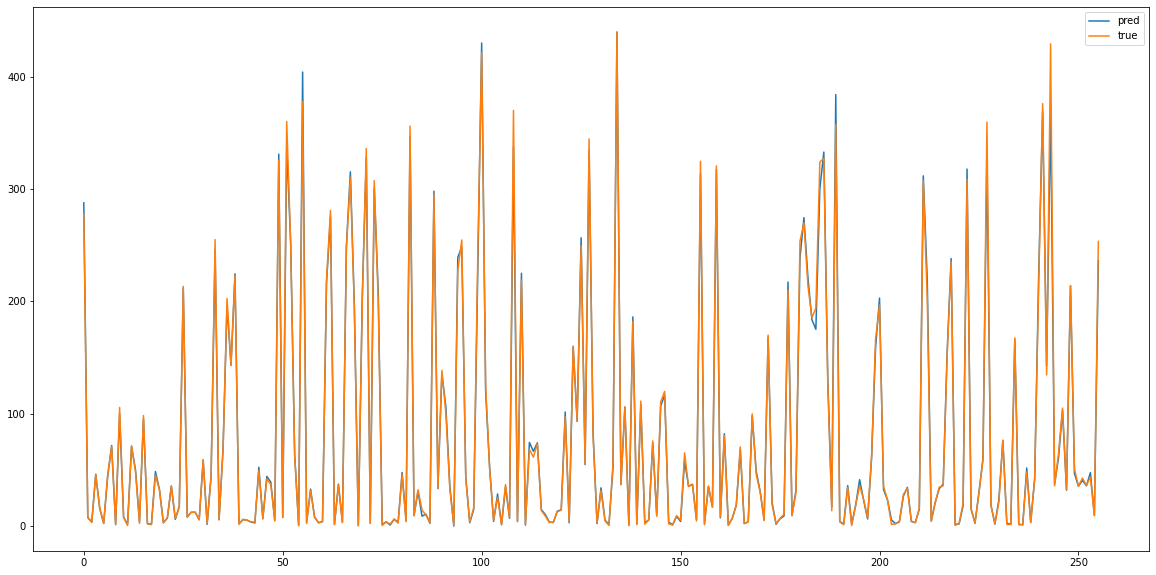

In [39]:
CATmodel = CatBoostRegressor(verbose=50, n_estimators=10000,  eval_metric='MAE', early_stopping_rounds=50)
CATmodel.fit(train_x, train_y, eval_set=[(val_x, val_y)],
                   use_best_model=True)

val_pred = CATmodel.predict(val_x)
plt.figure(figsize=(20,10))
plt.plot(np.array(val_pred),label = "pred")
plt.plot(np.array(val_y),label = "true")
plt.legend()
plt.show()

train_score = CATmodel.score(train_x, train_y) # train (learn) score

val_score = CATmodel.score(val_x, val_y) # val (test) score

In [32]:
CATresult = CATmodel.predict(test_col)

submission = pd.read_csv('./open/sample_submission.csv')
submission['leaf_weight'] = CATresult
submission.to_csv('./CATsubmit.csv', index=False)

## ANN Fit
-  싸이킷런(스케일러)로 메타데이터 스케일 조정
-  50번 이상 validation loss 개선 없을 경우 조기종료

In [33]:
def scale_datasets(x_train, x_test):
  """
  Standard Scale test and train data
  Z - Score normalization
  """
  standard_scaler = StandardScaler()
  x_train_scaled = pd.DataFrame(
      standard_scaler.fit_transform(x_train),
      columns=x_train.columns
  )
  x_test_scaled = pd.DataFrame(
      standard_scaler.transform(x_test),
      columns = x_test.columns
  )
  return x_train_scaled, x_test_scaled

train_scaled, test_scaled = scale_datasets(train_col, test_col)

train_x_scale, val_x_scale, train_y_scale, val_y_scale = train_test_split(train_scaled, train_target, test_size=0.2, random_state=32)

In [63]:
# Creating model using the Sequential in tensorflow

tf.random.set_seed(42)

def build_model_using_sequential():
  model = Sequential([
    Dense(100, kernel_initializer='normal', activation='relu'),
    Dense(50, kernel_initializer='normal', activation='relu'),
    Dense(25, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])
  return model
# build the model
ANNmodel = build_model_using_sequential()

# loss function
mae = MeanAbsoluteError()
ANNmodel.compile(
    loss=mae, 
    optimizer=Adam(learning_rate=0.001), 
    metrics=[mae]
)

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=50,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

# train the model
history = ANNmodel.fit(
    train_x_scale, 
    train_y_scale, 
    epochs=1000, 
    batch_size=32,
    validation_data=(val_x_scale, val_y_scale),
    callbacks=[early_stopping_monitor],
    verbose= 2
)

Epoch 1/1000
32/32 - 1s - loss: 79.6744 - mean_absolute_error: 79.6432 - val_loss: 80.6484 - val_mean_absolute_error: 80.6484 - 809ms/epoch - 25ms/step
Epoch 2/1000
32/32 - 0s - loss: 77.6729 - mean_absolute_error: 77.6479 - val_loss: 76.2712 - val_mean_absolute_error: 76.2712 - 56ms/epoch - 2ms/step
Epoch 3/1000
32/32 - 0s - loss: 68.8186 - mean_absolute_error: 68.8400 - val_loss: 64.2809 - val_mean_absolute_error: 64.2809 - 86ms/epoch - 3ms/step
Epoch 4/1000
32/32 - 0s - loss: 53.4525 - mean_absolute_error: 53.4092 - val_loss: 47.9984 - val_mean_absolute_error: 47.9984 - 71ms/epoch - 2ms/step
Epoch 5/1000
32/32 - 0s - loss: 39.6289 - mean_absolute_error: 39.6271 - val_loss: 33.7400 - val_mean_absolute_error: 33.7400 - 97ms/epoch - 3ms/step
Epoch 6/1000
32/32 - 0s - loss: 26.6963 - mean_absolute_error: 26.6739 - val_loss: 19.7237 - val_mean_absolute_error: 19.7237 - 61ms/epoch - 2ms/step
Epoch 7/1000
32/32 - 0s - loss: 15.0236 - mean_absolute_error: 15.0145 - val_loss: 10.1331 - val_m

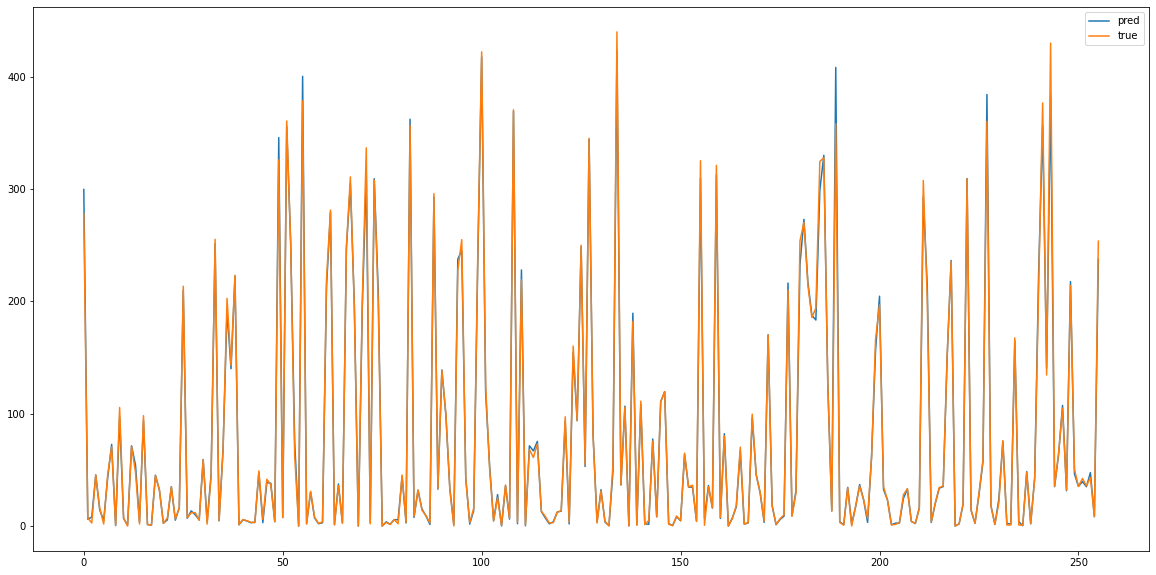

In [35]:
val_pred = ANNmodel.predict(val_x_scale)
plt.figure(figsize=(20,10))
plt.plot(np.array(val_pred),label = "pred")
plt.plot(np.array(val_y_scale),label = "true")
plt.legend()
plt.show()

In [36]:
ANNresult = ANNmodel.predict(test_scaled)

submission = pd.read_csv('./open/sample_submission.csv')
submission['leaf_weight'] = ANNresult
submission.to_csv('./ANNsubmit.csv', index=False)

## Ensemble

-  각 모델 결과 비교하면서 public score가 더 좋을수록 가중치 높게 적용
-  CNN (0.152884733) * 0.65 + CatBoost (0.2221573479) * 0.25 + Ann (0.2557698871) * 0.1

In [37]:
CNN = pd.read_csv('./CNNsubmit.csv')
CAT = pd.read_csv('./CATsubmit.csv')
ANN = pd.read_csv('./ANNsubmit.csv')

submission_final = pd.read_csv('./open/sample_submission.csv')
submission_final['leaf_weight'] = (CNN['leaf_weight'] * 0.65 + CAT['leaf_weight'] * 0.25 + ANN['leaf_weight'] * 0.1)
submission_final.to_csv('ENSEMBLEsubmit.csv', index=False)